In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet18
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 42
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

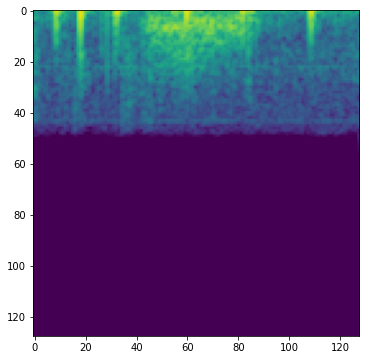

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.7320556886689449
TEST
loss: 1.455868301315913
accuracy: 0.5714285714285714
******************
epoch: 1
Train
0.6224870178981656
TEST
loss: 0.8372160731800019
accuracy: 0.638095238095238
******************
epoch: 2
Train
0.5298901336641895
TEST
loss: 0.5812984971773056
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.43863067149263796
TEST
loss: 1.309981532323928
accuracy: 0.20634920634920634
******************
epoch: 4
Train
0.4193881321654043
TEST
loss: 0.7243046174919795
accuracy: 0.8126984126984127
******************
epoch: 5
Train
0.36282850943973277
TEST
loss: 0.6112739298078749
accuracy: 0.7301587301587301
******************
epoch: 6
Train
0.3474947298811105
TEST
loss: 0.859945727719201
accuracy: 0.5968253968253968
******************
epoch: 7
Train
0.3247612020011172
TEST
loss: 0.8107903302661956
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.2650213571675151
TEST
loss: 0.7167950819409082
accuracy: 0.7873015873015873
************

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8527918781725888


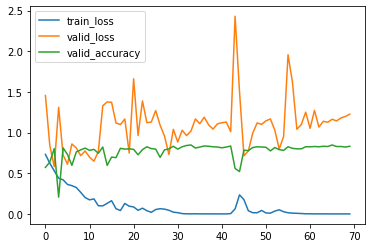

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8046913098446238
TEST
loss: 1.903521572597443
accuracy: 0.3523809523809524
******************
epoch: 1
Train
0.6035518207372039
TEST
loss: 0.5849956381888617
accuracy: 0.7873015873015873
******************
epoch: 2
Train
0.5756686639700549
TEST
loss: 0.5735782075495947
accuracy: 0.7873015873015873
******************
epoch: 3
Train
0.5082607708392018
TEST
loss: 0.527508619948039
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.472739171748648
TEST
loss: 0.7073649966527545
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.4249648964528151
TEST
loss: 1.0127750900056627
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.47550917069432846
TEST
loss: 0.653463243681287
accuracy: 0.7841269841269841
******************
epoch: 7
Train
0.3844176471186025
TEST
loss: 0.9758741450688195
accuracy: 0.638095238095238
******************
epoch: 8
Train
0.36041918325935496
TEST
loss: 0.6549436991649961
accuracy: 0.6

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8375634517766497


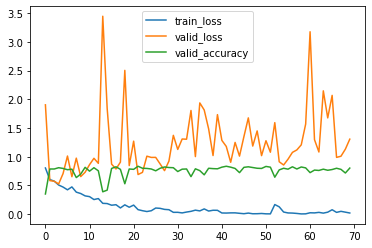

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8074793589313983
TEST
loss: 0.9477346140240867
accuracy: 0.6317460317460317
******************
epoch: 1
Train
0.595674170493322
TEST
loss: 0.5852848056762937
accuracy: 0.7936507936507936
******************
epoch: 2
Train
0.54109224072281
TEST
loss: 0.6810657746262021
accuracy: 0.8
******************
epoch: 3
Train
0.47050358952748766
TEST
loss: 0.6488563789261712
accuracy: 0.7936507936507936
******************
epoch: 4
Train
0.4756683223807594
TEST
loss: 0.6872129614391024
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.41359064605522006
TEST
loss: 0.7707806787793599
accuracy: 0.5873015873015873
******************
epoch: 6
Train
0.4454205906561578
TEST
loss: 0.5488171594483512
accuracy: 0.8063492063492064
******************
epoch: 7
Train
0.3453290922429658
TEST
loss: 0.7636967484913175
accuracy: 0.6349206349206349
******************
epoch: 8
Train
0.32750791824933934
TEST
loss: 1.5489621529503474
accuracy: 0.6825396825396

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


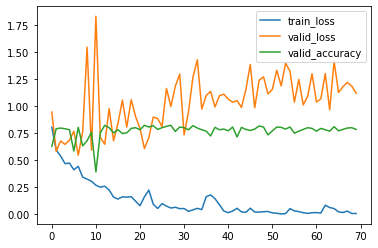

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7634162308442584
TEST
loss: 0.6154426732706645
accuracy: 0.7682539682539683
******************
epoch: 1
Train
0.5673602651375641
TEST
loss: 0.7652322910134755
accuracy: 0.7396825396825397
******************
epoch: 2
Train
0.4845518156637551
TEST
loss: 0.6249855715131003
accuracy: 0.7714285714285715
******************
epoch: 3
Train
0.39875335417350577
TEST
loss: 0.6358316751699599
accuracy: 0.8
******************
epoch: 4
Train
0.380680183648495
TEST
loss: 0.6880257564877706
accuracy: 0.7428571428571429
******************
epoch: 5
Train
0.39482939622059426
TEST
loss: 0.9241617874493675
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.2678076052850348
TEST
loss: 0.6577736770349836
accuracy: 0.7428571428571429
******************
epoch: 7
Train
0.2725803374155255
TEST
loss: 1.8038479895818802
accuracy: 0.726984126984127
******************
epoch: 8
Train
0.20475112187000757
TEST
loss: 0.7165632931959062
accuracy: 0.717460317460

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


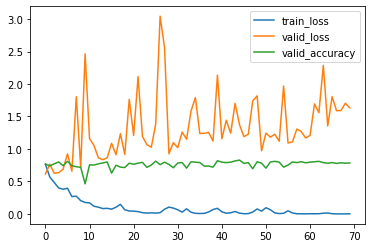

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7461444400813108
TEST
loss: 0.6121156044422634
accuracy: 0.7777777777777778
******************
epoch: 1
Train
0.5911924556856405
TEST
loss: 0.9582465449968974
accuracy: 0.5396825396825397
******************
epoch: 2
Train
0.5461481648176979
TEST
loss: 0.605381356061451
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.4382955929038068
TEST
loss: 0.5732107855970897
accuracy: 0.8253968253968254
******************
epoch: 4
Train
0.40801187798179644
TEST
loss: 0.7231328351157053
accuracy: 0.7396825396825397
******************
epoch: 5
Train
0.3623363958690922
TEST
loss: 0.8618833443475148
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.33670619773997307
TEST
loss: 0.5290814638137817
accuracy: 0.7746031746031746
******************
epoch: 7
Train
0.3164049737788648
TEST
loss: 0.851483897841166
accuracy: 0.7555555555555555
******************
epoch: 8
Train
0.2667974077455102
TEST
loss: 0.6636472493883163
accuracy: 

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


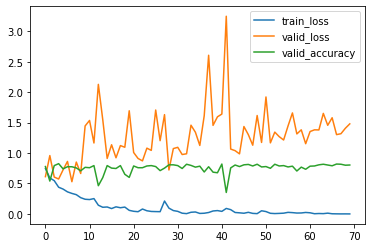

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8262582992730962
TEST
loss: 1.1983781055798606
accuracy: 0.5904761904761905
******************
epoch: 1
Train
0.6356396321932223
TEST
loss: 0.854785367326131
accuracy: 0.7111111111111111
******************
epoch: 2
Train
0.5991019248915059
TEST
loss: 0.5889522708597638
accuracy: 0.7841269841269841
******************
epoch: 3
Train
0.5220813745539561
TEST
loss: 2.541928091503325
accuracy: 0.273015873015873
******************
epoch: 4
Train
0.4849415862721238
TEST
loss: 0.6085210004496195
accuracy: 0.8031746031746032
******************
epoch: 5
Train
0.45427283605618357
TEST
loss: 0.6585410791730124
accuracy: 0.7873015873015873
******************
epoch: 6
Train
0.45478949207602465
TEST
loss: 0.5170830089894553
accuracy: 0.8317460317460318
******************
epoch: 7
Train
0.44701563966378416
TEST
loss: 0.5497404355378378
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.4265948906481692
TEST
loss: 0.575965161266781
accuracy: 0

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8604060913705583


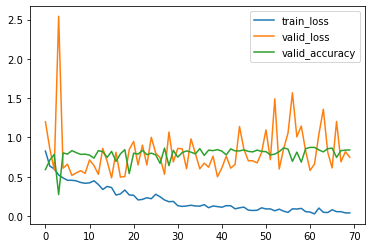

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9437264116204287
TEST
loss: 0.6208986499952891
accuracy: 0.7904761904761904
******************
epoch: 1
Train
0.7343325440707521
TEST
loss: 0.8250496873779902
accuracy: 0.6476190476190476
******************
epoch: 2
Train
0.6809971316926909
TEST
loss: 0.6394459754701645
accuracy: 0.7523809523809524
******************
epoch: 3
Train
0.6210347888865482
TEST
loss: 0.5819908250891973
accuracy: 0.7904761904761904
******************
epoch: 4
Train
0.6238966986146401
TEST
loss: 0.5706557007063002
accuracy: 0.7936507936507936
******************
epoch: 5
Train
0.6035512062743886
TEST
loss: 0.592840964642782
accuracy: 0.7714285714285715
******************
epoch: 6
Train
0.5735361325163232
TEST
loss: 0.6079683621724447
accuracy: 0.7936507936507936
******************
epoch: 7
Train
0.5844122215904254
TEST
loss: 0.6994034151236216
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.5981265080410683
TEST
loss: 0.5986485595740969
accuracy: 0

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


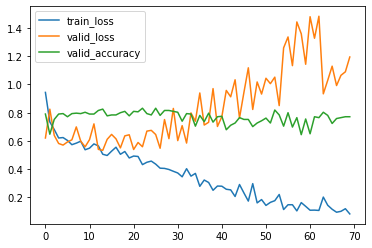

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9275142532478163
TEST
loss: 2.158036308439951
accuracy: 0.6793650793650794
******************
epoch: 1
Train
0.7262843290522896
TEST
loss: 1.8209671410303268
accuracy: 0.6761904761904762
******************
epoch: 2
Train
0.6661953924192712
TEST
loss: 1.3155879474821546
accuracy: 0.6793650793650794
******************
epoch: 3
Train
0.5821371078491211
TEST
loss: 0.8754830803189959
accuracy: 0.5587301587301587
******************
epoch: 4
Train
0.5432249140038766
TEST
loss: 0.6660123791013445
accuracy: 0.7714285714285715
******************
epoch: 5
Train
0.5243892355913014
TEST
loss: 0.7544873663357325
accuracy: 0.707936507936508
******************
epoch: 6
Train
0.5159189189540857
TEST
loss: 0.9320043213783749
accuracy: 0.7365079365079366
******************
epoch: 7
Train
0.4939750645537524
TEST
loss: 0.5490994086341252
accuracy: 0.8126984126984127
******************
epoch: 8
Train
0.44194746007987484
TEST
loss: 0.7604722394829705
accuracy: 0

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7817258883248731


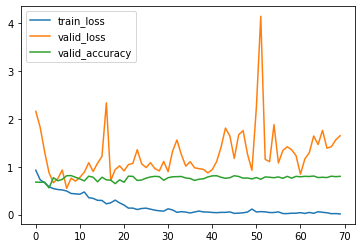

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.788535592170629
TEST
loss: 2.3320876662693326
accuracy: 0.36507936507936506
******************
epoch: 1
Train
0.5293389201590332
TEST
loss: 0.6902744167380863
accuracy: 0.7746031746031746
******************
epoch: 2
Train
0.44780446928678
TEST
loss: 0.6599607336142707
accuracy: 0.7714285714285715
******************
epoch: 3
Train
0.4295613819687399
TEST
loss: 0.6133765508258153
accuracy: 0.8222222222222222
******************
epoch: 4
Train
0.393793803628614
TEST
loss: 0.6892882354675778
accuracy: 0.7301587301587301
******************
epoch: 5
Train
0.37684565212065685
TEST
loss: 0.5700598039324322
accuracy: 0.8
******************
epoch: 6
Train
0.3403271236904469
TEST
loss: 0.6404755662357996
accuracy: 0.8158730158730159
******************
epoch: 7
Train
0.27618581624709015
TEST
loss: 1.2994670888734243
accuracy: 0.4380952380952381
******************
epoch: 8
Train
0.21678728897293187
TEST
loss: 1.0193062470072791
accuracy: 0.7015873015873

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


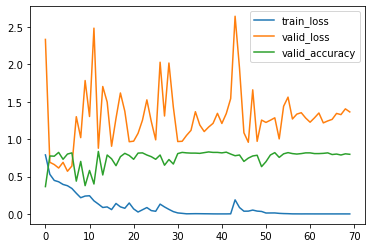

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8034765898139823
TEST
loss: 3.3354418345860073
accuracy: 0.30793650793650795
******************
epoch: 1
Train
0.5384292893460859
TEST
loss: 0.5676739713502309
accuracy: 0.7904761904761904
******************
epoch: 2
Train
0.4759951409979223
TEST
loss: 0.916565259676131
accuracy: 0.7365079365079366
******************
epoch: 3
Train
0.4502083250603286
TEST
loss: 0.6492622448811456
accuracy: 0.819047619047619
******************
epoch: 4
Train
0.4202608804649735
TEST
loss: 0.9611333126113528
accuracy: 0.6825396825396826
******************
epoch: 5
Train
0.43308860622198453
TEST
loss: 0.7142992462430682
accuracy: 0.7333333333333333
******************
epoch: 6
Train
0.3534154407177017
TEST
loss: 0.6970238469895862
accuracy: 0.7492063492063492
******************
epoch: 7
Train
0.29899209931883386
TEST
loss: 1.1655225666742477
accuracy: 0.7587301587301587
******************
epoch: 8
Train
0.22217889292264761
TEST
loss: 0.7694320954973736
accuracy

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


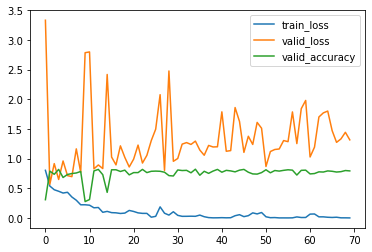

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8063750425272276
TEST
loss: 1.6916178623835245
accuracy: 0.44126984126984126
******************
epoch: 1
Train
0.6571741614008442
TEST
loss: 0.6644405608139341
accuracy: 0.7174603174603175
******************
epoch: 2
Train
0.5736747305482224
TEST
loss: 0.6667845236876654
accuracy: 0.7428571428571429
******************
epoch: 3
Train
0.5210067747697837
TEST
loss: 0.6865349007031274
accuracy: 0.7523809523809524
******************
epoch: 4
Train
0.490778013247171
TEST
loss: 0.589593173587133
accuracy: 0.819047619047619
******************
epoch: 5
Train
0.4753964724428981
TEST
loss: 0.5923924219040644
accuracy: 0.765079365079365
******************
epoch: 6
Train
0.4642064705242516
TEST
loss: 0.7103585234710148
accuracy: 0.7714285714285715
******************
epoch: 7
Train
0.4536732654897252
TEST
loss: 0.7772182761676728
accuracy: 0.653968253968254
******************
epoch: 8
Train
0.42331551356245545
TEST
loss: 0.7549236882300604
accuracy: 0.7

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8527918781725888


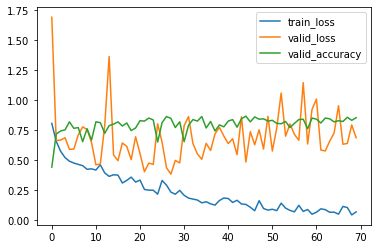

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.971060886162439
TEST
loss: 2.614760614576794
accuracy: 0.2984126984126984
******************
epoch: 1
Train
0.6883035177650482
TEST
loss: 0.6304758059600043
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.6901078120027865
TEST
loss: 0.6873215066062079
accuracy: 0.780952380952381
******************
epoch: 3
Train
0.6339894937465265
TEST
loss: 0.7386438360289922
accuracy: 0.7365079365079366
******************
epoch: 4
Train
0.6348689513797321
TEST
loss: 0.7143720773477403
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.6058188958997477
TEST
loss: 0.703315882644956
accuracy: 0.7174603174603175
******************
epoch: 6
Train
0.5905596601338118
TEST
loss: 0.6155631876181042
accuracy: 0.8063492063492064
******************
epoch: 7
Train
0.5890566514918878
TEST
loss: 0.815789747048938
accuracy: 0.6857142857142857
******************
epoch: 8
Train
0.5829647347224526
TEST
loss: 0.5042674565126025
accuracy: 0.822

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


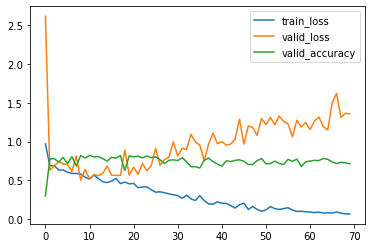

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.8052553766487703
TEST
loss: 0.7649190880003429
accuracy: 0.726984126984127
******************
epoch: 1
Train
0.6631488846918246
TEST
loss: 0.5570587388106755
accuracy: 0.7968253968253968
******************
epoch: 2
Train
0.5953076083192378
TEST
loss: 0.6742490546097831
accuracy: 0.7714285714285715
******************
epoch: 3
Train
0.5364597194293267
TEST
loss: 1.102128791809082
accuracy: 0.5492063492063493
******************
epoch: 4
Train
0.5144173686138878
TEST
loss: 0.5355835662947761
accuracy: 0.8
******************
epoch: 5
Train
0.4751092236462427
TEST
loss: 0.452542407550509
accuracy: 0.8412698412698413
******************
epoch: 6
Train
0.4860710012737582
TEST
loss: 0.5357222295942761
accuracy: 0.8317460317460318
******************
epoch: 7
Train
0.4595332589293397
TEST
loss: 0.6412495488212222
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.42011101920870775
TEST
loss: 0.5926424840139964
accuracy: 0.780952380952381

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8553299492385786


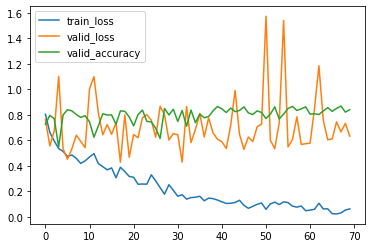

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.96610939119239
TEST
loss: 1.6132688374746413
accuracy: 0.4857142857142857
******************
epoch: 1
Train
0.735377200403509
TEST
loss: 0.6401313590624976
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.7111262805505439
TEST
loss: 0.6849341788935283
accuracy: 0.7365079365079366
******************
epoch: 3
Train
0.6553968390933667
TEST
loss: 0.592088763770603
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.6265971065514423
TEST
loss: 0.594900993033061
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.6155019704077904
TEST
loss: 0.5495445215512835
accuracy: 0.8158730158730159
******************
epoch: 6
Train
0.6095134774023242
TEST
loss: 0.5544694632764846
accuracy: 0.8158730158730159
******************
epoch: 7
Train
0.58693123370338
TEST
loss: 0.5833486276013511
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.5993037496984147
TEST
loss: 0.6228254124285683
accuracy: 0.79365

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8071065989847716


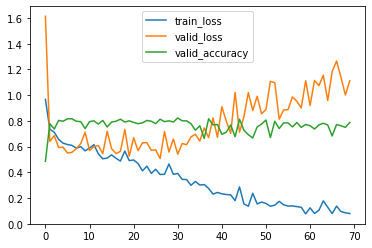

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7703770902821523
TEST
loss: 0.7181591664041792
accuracy: 0.7301587301587301
******************
epoch: 1
Train
0.6108862695190241
TEST
loss: 0.7722702522126456
accuracy: 0.6571428571428571
******************
epoch: 2
Train
0.5517961975124925
TEST
loss: 0.5541193312122709
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.4652891063425066
TEST
loss: 0.595360013038393
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.45040488011123075
TEST
loss: 0.5380626341653248
accuracy: 0.834920634920635
******************
epoch: 5
Train
0.4063202600047359
TEST
loss: 0.5874043424924215
accuracy: 0.780952380952381
******************
epoch: 6
Train
0.3615719011324185
TEST
loss: 0.6382289998588108
accuracy: 0.8095238095238095
******************
epoch: 7
Train
0.36218350453448733
TEST
loss: 0.742407725160084
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.31278762732639115
TEST
loss: 0.5716863272682069
accuracy: 0

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


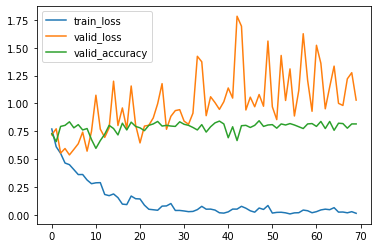

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7565864916355294
TEST
loss: 4.078202456519717
accuracy: 0.2920634920634921
******************
epoch: 1
Train
0.6093286474230177
TEST
loss: 0.6491354180706872
accuracy: 0.765079365079365
******************
epoch: 2
Train
0.5310285327167527
TEST
loss: 0.6410927102679298
accuracy: 0.7015873015873015
******************
epoch: 3
Train
0.4576366384461155
TEST
loss: 0.8768880696523758
accuracy: 0.43174603174603177
******************
epoch: 4
Train
0.4203561431742358
TEST
loss: 0.578379842402443
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.3685645543695727
TEST
loss: 1.001603465042417
accuracy: 0.638095238095238
******************
epoch: 6
Train
0.35108822986566424
TEST
loss: 0.6847195577053796
accuracy: 0.8031746031746032
******************
epoch: 7
Train
0.3288176469711958
TEST
loss: 0.6748287453064843
accuracy: 0.7936507936507936
******************
epoch: 8
Train
0.3163480719372429
TEST
loss: 0.642441761682904
accuracy: 0.752

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7842639593908629


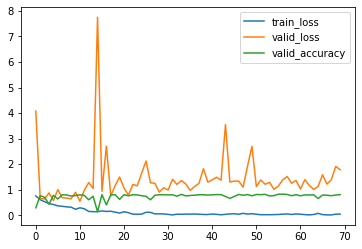

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7392056550744793
TEST
loss: 0.5737991605486189
accuracy: 0.7904761904761904
******************
epoch: 1
Train
0.5892285632651604
TEST
loss: 1.6139050680493552
accuracy: 0.35555555555555557
******************
epoch: 2
Train
0.5326960813061787
TEST
loss: 0.7221469353115748
accuracy: 0.7428571428571429
******************
epoch: 3
Train
0.4595535302607193
TEST
loss: 0.6151594239094901
accuracy: 0.7968253968253968
******************
epoch: 4
Train
0.46985920707416307
TEST
loss: 0.5342423307517218
accuracy: 0.8063492063492064
******************
epoch: 5
Train
0.3742174634249841
TEST
loss: 1.1010014874594551
accuracy: 0.473015873015873
******************
epoch: 6
Train
0.33801716641834373
TEST
loss: 0.6547469583768694
accuracy: 0.8
******************
epoch: 7
Train
0.3007983974135992
TEST
loss: 0.9566236081577483
accuracy: 0.6793650793650794
******************
epoch: 8
Train
0.2953057752254939
TEST
loss: 0.6334343632062276
accuracy: 0.82222222222

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.850253807106599


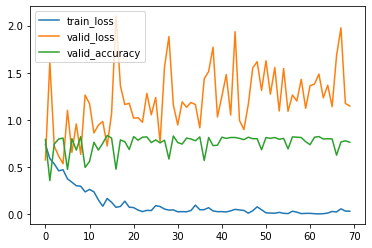

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.7404791125946333
TEST
loss: 2.934681311107817
accuracy: 0.33650793650793653
******************
epoch: 1
Train
0.6121253264717302
TEST
loss: 0.6405620035671052
accuracy: 0.7746031746031746
******************
epoch: 2
Train
0.5657228596443407
TEST
loss: 0.843245578001416
accuracy: 0.7111111111111111
******************
epoch: 3
Train
0.4733168455558319
TEST
loss: 0.7510791433235956
accuracy: 0.6825396825396826
******************
epoch: 4
Train
0.4194901865848575
TEST
loss: 0.723035354652102
accuracy: 0.7714285714285715
******************
epoch: 5
Train
0.39790285604164843
TEST
loss: 0.7220456613434686
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.4154755584392593
TEST
loss: 0.8594464377751426
accuracy: 0.6476190476190476
******************
epoch: 7
Train
0.3881292869118682
TEST
loss: 0.6720316288963196
accuracy: 0.7936507936507936
******************
epoch: 8
Train
0.3073694991677218
TEST
loss: 0.9159454869845557
accuracy: 0

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


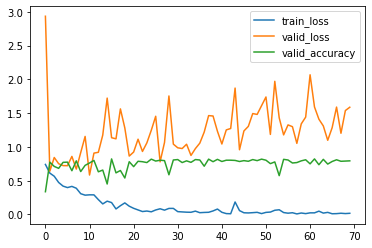

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.780908481529348
TEST
loss: 1.7857447306315104
accuracy: 0.4666666666666667
******************
epoch: 1
Train
0.6146443626348512
TEST
loss: 0.8623655001322429
accuracy: 0.6063492063492063
******************
epoch: 2
Train
0.608295046923367
TEST
loss: 1.6734161986245049
accuracy: 0.3492063492063492
******************
epoch: 3
Train
0.512947492342889
TEST
loss: 0.5481172128329201
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.47497797178029066
TEST
loss: 0.509345337133559
accuracy: 0.8158730158730159
******************
epoch: 5
Train
0.399104078176762
TEST
loss: 2.5929061435517813
accuracy: 0.3142857142857143
******************
epoch: 6
Train
0.3587104462033894
TEST
loss: 0.754494409523313
accuracy: 0.6825396825396826
******************
epoch: 7
Train
0.38705311162875133
TEST
loss: 0.7885800795895713
accuracy: 0.7619047619047619
******************
epoch: 8
Train
0.3131113800266795
TEST
loss: 0.5632421093327659
accuracy: 0.78

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


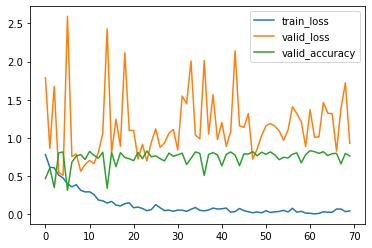

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9325826007804765
TEST
loss: 0.6966104013579232
accuracy: 0.7333333333333333
******************
epoch: 1
Train
0.6741823789332952
TEST
loss: 0.8324586003545731
accuracy: 0.6095238095238096
******************
epoch: 2
Train
0.5899783062783378
TEST
loss: 1.1750673322450547
accuracy: 0.473015873015873
******************
epoch: 3
Train
0.5357615946303104
TEST
loss: 0.5775174751168206
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.4719382768779449
TEST
loss: 1.2191879015120248
accuracy: 0.7365079365079366
******************
epoch: 5
Train
0.4405276855842948
TEST
loss: 0.8770118997210548
accuracy: 0.5904761904761905
******************
epoch: 6
Train
0.41484967418565366
TEST
loss: 0.6123561077647739
accuracy: 0.8126984126984127
******************
epoch: 7
Train
0.44277423965826784
TEST
loss: 0.5606582889481196
accuracy: 0.8126984126984127
******************
epoch: 8
Train
0.36382139808512376
TEST
loss: 0.6569982259046464
accuracy

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


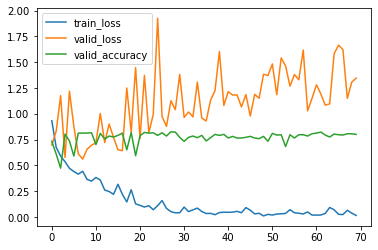

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()